## Foot Traffic Score
In order to get the Foot traffic score the <a href= "https://data.cityofnewyork.us/Transportation/2023-Yellow-Taxi-Trip-Data/4b4i-vvec/data_preview">Yellow Taxi data 2023</a> is used and cleaned with the relevant features. The Busyness of each census tract area is estimated by counting the pick ups and drop offs. Finally the score is joined with the census tract data.

In [1]:
# import packages
import pandas as pd

# Import package numpy for numeric computing
import numpy as np

# Import package matplotlib for visualisation/plotting
import matplotlib.pyplot as plt

#For showing plots directly in the notebook run the command below
%matplotlib inline

import geopandas as gpd

from shapely.geometry import Point

from haversine import haversine, Unit

from sklearn.preprocessing import MinMaxScaler

Get the Manhatten Zone IDs using taxi_zone_lookup.csv

In [2]:
zone_lookup = pd.read_csv('taxi_zone_lookup.csv', keep_default_na=True, delimiter=',', skipinitialspace=True)

In [3]:
zone_lookup.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [4]:
manhattan_zone_ids = zone_lookup[zone_lookup["Borough"] == "Manhattan"]["LocationID"].tolist()

In [5]:
yellow_taxi_data = pd.read_csv("2023_Yellow_Taxi_Trip_Data_20250530.csv", keep_default_na=True, delimiter=',', skipinitialspace=True)

In [6]:
yellow_taxi_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,tip_amount,total_amount
0,01/01/2023 12:32:10 AM,01/01/2023 12:40:36 AM,1.0,0.97,161,141,9.3,0.00,14.30
1,01/01/2023 12:55:08 AM,01/01/2023 01:01:27 AM,1.0,1.10,43,237,7.9,4.00,16.90
2,01/01/2023 12:25:04 AM,01/01/2023 12:37:49 AM,1.0,2.51,48,238,14.9,15.00,34.90
3,01/01/2023 12:03:48 AM,01/01/2023 12:13:25 AM,0.0,1.90,138,7,12.1,0.00,20.85
4,01/01/2023 12:10:29 AM,01/01/2023 12:21:19 AM,1.0,1.43,107,79,11.4,3.28,19.68


In [7]:
yellow_taxi_data.dtypes

tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count          float64
trip_distance            float64
PULocationID               int64
DOLocationID               int64
fare_amount              float64
tip_amount               float64
total_amount             float64
dtype: object

Filter for pick ups

In [8]:
yellow_taxi_data['tpep_pickup_datetime'] =  pd.to_datetime(yellow_taxi_data['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

In [9]:
yellow_taxi_data["hour"] = yellow_taxi_data["tpep_pickup_datetime"].dt.hour


In [10]:
# Filter for Manhatten pickups during daytime
yellow_taxi_data= yellow_taxi_data[
(yellow_taxi_data["PULocationID"].isin(manhattan_zone_ids)) 
& (yellow_taxi_data["hour"].between(7, 20)) & 
(yellow_taxi_data["passenger_count"] > 0)
]

Filter for drop offs

In [11]:
yellow_taxi_data['tpep_dropoff_datetime'] =  pd.to_datetime(yellow_taxi_data['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

In [12]:
yellow_taxi_data["hour_drop_off"] = yellow_taxi_data["tpep_dropoff_datetime"].dt.hour

In [13]:
# Filter for Manhatten drop offs during daytime
yellow_taxi_data= yellow_taxi_data[
(yellow_taxi_data["DOLocationID"].isin(manhattan_zone_ids)) 
& (yellow_taxi_data["hour_drop_off"].between(7, 20)) & 
(yellow_taxi_data["passenger_count"] > 0)
]

Joining data with TLC zone shapefile

In [14]:
#count the pick ups and drop offs
pickup_counts = yellow_taxi_data.groupby("PULocationID").size().reset_index(name="pickup_count")
dropoff_counts = yellow_taxi_data.groupby("DOLocationID").size().reset_index(name="dropoff_count")
zones = gpd.read_file("taxi_zones/taxi_zones.shp") 


In [15]:
# Merge filtered zones and pickup data and drop off data
zones = zones.merge(zone_lookup, left_on="LocationID", right_on="LocationID")
zones = zones[zones["Borough"] == "Manhattan"]
zones = zones.merge(pickup_counts, left_on="LocationID", right_on="PULocationID", how="left")
zones = zones.merge(dropoff_counts, left_on="LocationID", right_on="DOLocationID", how="left")
zones = zones.fillna(0)

In [16]:
#Normalize pick up and drop off data and scale to 1 - 10
scaler = MinMaxScaler((1, 10))
zones["dropoff_count"] = scaler.fit_transform(zones[["dropoff_count"]])
zones["pickup_count"] = scaler.fit_transform(zones[["pickup_count"]])

In [17]:
#Weighted sum of normalized values
zones["foot_traffic_score"] = (0.7 * zones["dropoff_count"] + 0.3 * zones["pickup_count"])

In [18]:
zones.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,Borough,Zone,service_zone,PULocationID,pickup_count,DOLocationID,dropoff_count,foot_traffic_score
0,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",Manhattan,Alphabet City,Yellow Zone,4.0,1.069113,4.0,1.513711,1.380332
1,12,0.036661,0.000042,Battery Park,12,Manhattan,"POLYGON ((979908.772 196066.565, 979980.852 19...",Manhattan,Battery Park,Yellow Zone,12.0,1.090841,12.0,1.132746,1.120175
2,13,0.050281,0.000149,Battery Park City,13,Manhattan,"POLYGON ((980801.31 201248.869, 980697.386 200...",Manhattan,Battery Park City,Yellow Zone,13.0,2.068338,13.0,2.338709,2.257598
3,24,0.047000,0.000061,Bloomingdale,24,Manhattan,"POLYGON ((995453.114 230274.267, 995312.583 23...",Manhattan,Bloomingdale,Yellow Zone,24.0,1.462074,24.0,1.545937,1.520778
4,41,0.052793,0.000143,Central Harlem,41,Manhattan,"POLYGON ((998716.913 234240.397, 999458.736 23...",Manhattan,Central Harlem,Boro Zone,41.0,1.373980,41.0,1.865287,1.717895


In [19]:
zones= zones.drop(['OBJECTID','zone','borough','Borough','LocationID'],axis=1)

In [20]:
zones.dtypes

Shape_Leng             float64
Shape_Area             float64
geometry              geometry
Zone                    object
service_zone            object
PULocationID           float64
pickup_count           float64
DOLocationID           float64
dropoff_count          float64
foot_traffic_score     float64
dtype: object

In [21]:
zones['PULocationID'] = zones['PULocationID'].astype('Int32')
zones['DOLocationID'] = zones['DOLocationID'].astype('Int32')

In [22]:
zones.head()

,Shape_Leng,Shape_Area,geometry,Zone,service_zone,PULocationID,pickup_count,DOLocationID,dropoff_count,foot_traffic_score
0,0.043567,0.000112,"POLYGON ((992073.467 203714.076, 992068.667 20...",Alphabet City,Yellow Zone,4,1.069113,4,1.513711,1.380332
1,0.036661,0.000042,"POLYGON ((979908.772 196066.565, 979980.852 19...",Battery Park,Yellow Zone,12,1.090841,12,1.132746,1.120175
2,0.050281,0.000149,"POLYGON ((980801.31 201248.869, 980697.386 200...",Battery Park City,Yellow Zone,13,2.068338,13,2.338709,2.257598
3,0.047000,0.000061,"POLYGON ((995453.114 230274.267, 995312.583 23...",Bloomingdale,Yellow Zone,24,1.462074,24,1.545937,1.520778
4,0.052793,0.000143,"POLYGON ((998716.913 234240.397, 999458.736 23...",Central Harlem,Boro Zone,41,1.373980,41,1.865287,1.717895


In [23]:
#zones.to_file("manhatten_foot_traffic_scores.geojsn", driver=GeoJSON)
zones.to_csv("manhatten_foot_traffic_scores.csv", index=False)

# Spatial Join

In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load foot traffic CSV (ALREADY in EPSG:2263)
# -------------------------------
df = pd.read_csv("manhatten_foot_traffic_scores.csv")
df["geometry"] = df["geometry"].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:2263")
gdf = gdf[gdf.is_valid]

print("✅ Loaded foot traffic data")
print(f"gdf shape: {gdf.shape}")
print(f"gdf bounds: {gdf.total_bounds}")

# -------------------------------
# 2. Load census tracts and reproject
# -------------------------------
tracts = gpd.read_file("../census tract geofiles/manhattan_census_tracts.geojson")
tracts_proj = tracts.to_crs(epsg=2263)

print("✅ Loaded census tract data")
print(f"tracts shape: {tracts_proj.shape}")
print(f"tracts bounds: {tracts_proj.total_bounds}")

# -------------------------------
# 3. Spatial overlay
# -------------------------------
overlay = gpd.overlay(gdf, tracts_proj, how="intersection")

print("✅ Spatial overlay done")
print(f"Overlay result shape: {overlay.shape}")
if overlay.empty:
    print("❌ WARNING: No intersections found!")

# -------------------------------
# 4. Area-weighted scoring
# -------------------------------
overlay["intersect_area"] = overlay.geometry.area
overlay["weighted_score"] = overlay["foot_traffic_score"] * overlay["intersect_area"]

# -------------------------------
# 5. Group by tract
# -------------------------------
grouped = overlay.groupby("GEOID").agg(
    total_weighted_score=("weighted_score", "sum"),
    total_area=("intersect_area", "sum")
).reset_index()

grouped["foot_traffic_score"] = grouped["total_weighted_score"] / grouped["total_area"]
tract_scores = grouped[["GEOID", "foot_traffic_score"]]

# -------------------------------
# 6. Fill in missing tracts with 0
# -------------------------------
all_tracts = tracts_proj[["GEOID"]].drop_duplicates()
final_scores = all_tracts.merge(tract_scores, on="GEOID", how="left")
final_scores["foot_traffic_score"] = final_scores["foot_traffic_score"].fillna(0)

print("✅ Final tract-level scores prepared")
print(final_scores.head())

# -------------------------------
# 7. Export result
# -------------------------------
final_scores["foot_traffic_score"] = final_scores["foot_traffic_score"].round(2)
final_scores.to_csv("foot_traffic_scores_by_tract.csv", index=False)
print("✅ Saved: foot_traffic_scores_by_tract.csv with shape:", final_scores.shape)


✅ Loaded foot traffic data
gdf shape: (69, 10)
gdf bounds: [ 971013.48821607  188082.32238773 1010061.70284013  259547.77027367]
✅ Loaded census tract data
tracts shape: (310, 10)
tracts bounds: [ 971013.48803711  188082.32238764 1010065.6472168   259547.77020259]
✅ Spatial overlay done
Overlay result shape: (826, 19)
✅ Final tract-level scores prepared
         GEOID  foot_traffic_score
0  36061000100            1.000000
1  36061001401            1.531531
2  36061001402            1.531531
3  36061001800            2.116937
4  36061002201            1.531531
✅ Saved: foot_traffic_scores_by_tract.csv with shape: (310, 2)


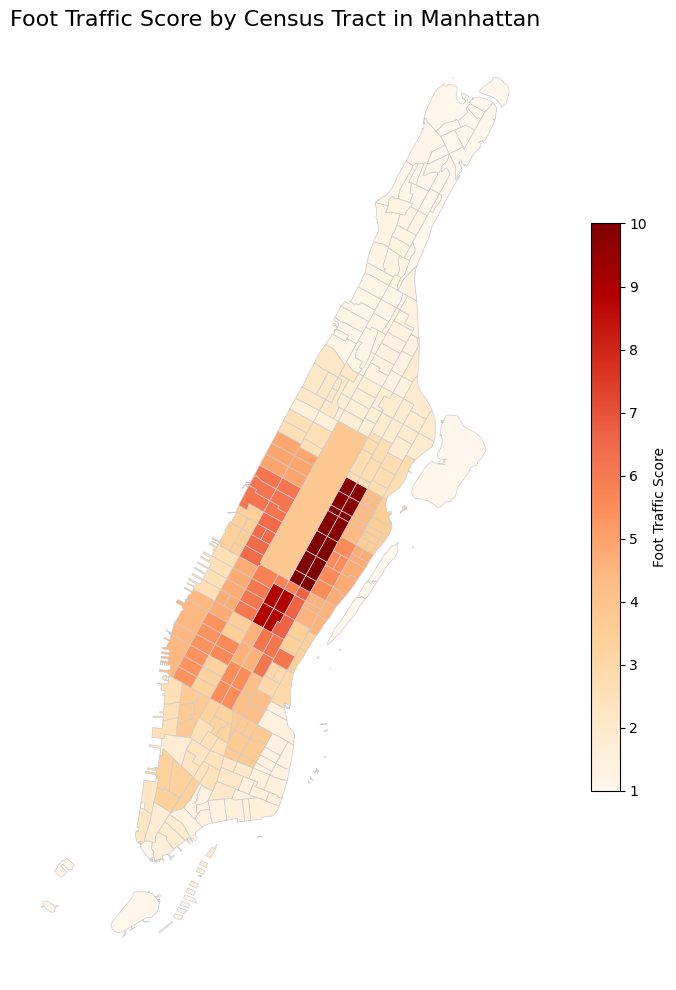

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the final scores
scores_df = pd.read_csv("foot_traffic_scores_by_tract.csv")
tracts = gpd.read_file("../census tract geofiles/manhattan_census_tracts.geojson")

# Merge scores with geometries
tracts = tracts[["GEOID", "geometry"]]
final_map = tracts.merge(scores_df, on="GEOID", how="left")

# Fill any missing scores with 0 (optional)
final_map["foot_traffic_score"] = final_map["foot_traffic_score"].fillna(0)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
final_map.plot(column="foot_traffic_score",
               cmap="OrRd",
               linewidth=0.5,
               ax=ax,
               edgecolor="0.8",
               legend=True,
               legend_kwds={"label": "Foot Traffic Score", "shrink": 0.6})

ax.set_title("Foot Traffic Score by Census Tract in Manhattan", fontsize=16)
ax.axis("off")
plt.tight_layout()
plt.show()